<a href="https://colab.research.google.com/github/gizemkaratas/DATA-LEARNING/blob/main/Outliers_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Gereken Kütüphanelerin Kullanılması
import numpy as np
import pandas as pd
import seaborn as sns #görselleştirme için kullanılır
from matplotlib import pyplot as plt
# !pip install missingno #aykırı değerler kütüphanesi
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.datasets import load_iris

In [ ]:
df =pd.read_csv("titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


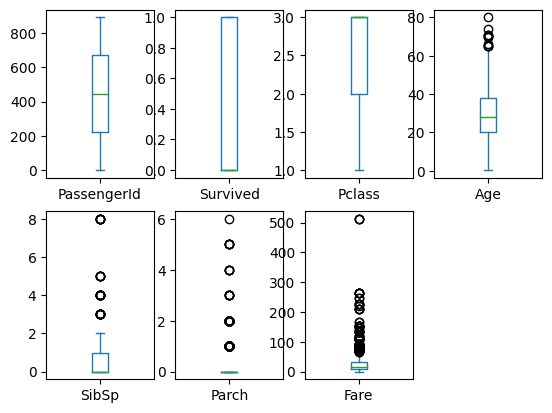

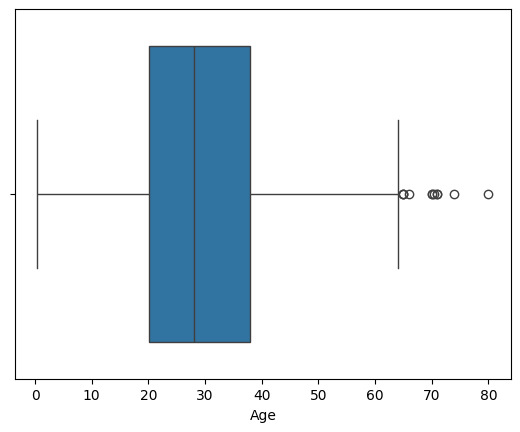

In [ ]:
# Grafik Teknikle Aykırı Değerler
df.plot(kind="box",subplots=True,layout=(2,4))
plt.show()
sns.boxplot(x=df["Age"])
plt.show()

In [ ]:
# İşlemleri Fonksiyonlaştırmak
###################


def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

outlier_thresholds(df, "Age")
outlier_thresholds(df, "Fare")

low, up = outlier_thresholds(df, "Fare")

df[(df["Fare"] < low) | (df["Fare"] > up)].head()


df[(df["Fare"] < low) | (df["Fare"] > up)].index

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

check_outlier(df, "Age")
check_outlier(df, "Fare")

True

In [ ]:
def check_outlier(dataframe, col_name): #direkt aykırı değer indeksi getirmek ya da headlemek yerine verinin içinde var mı yok mu diye fonksiyon döndürürüz boolean
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None): #colon lowdan küçük veya büyük mü
        return True
    else:
        return False

check_outlier(df, "Age")
check_outlier(df, "Fare")

True

In [ ]:
# Aykırı değer fonksiyonlaştırma bunu başka projelerde de kullanabiliriz.# sürekli kolonların adını yazıp aratmak yerine bunu otomatikleştirelim değişken sayısı arttıkça bunla baş etmek zorlaşır
def grab_col_names(dataframe, cat_th=10, car_th=20): # cat_th:10 kategorik olduğunu 10 dan az sınıf varsa kategoriktir, car_th=20 sınıf sayısı 20 dan fazla ise anlamsız kardinal olarak belirledik bu değiştirilebilir.
    """

    Veri setindeki kategorik, sayısal ve kategorik fakat kardinal değişkenlerin isimlerini verir.(çeşitliliği fazla ama bilgi değeri düşük örn name gibi)
    Not: Kategorik değişkenlerin içerisine sayısal görünümlü kategorik değişkenler de dahildir.

    Parametreler
    ------
        df: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, opsiyonel
                Sayısal fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, opsiyonel
                Kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Dönenler
    ------
        cat_cols: liste
                Kategorik değişken listesi
        num_cols: liste
                Sayısal değişken listesi
        cat_but_car: liste
                Kategorik görünümlü kardinal değişken listesi

    Örnekler
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notlar
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisindedir.
        Dönen 3 liste toplamı, toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"] #buradaki 0 objecti temsil ediyor
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and # eğer 10 farlı değerden azsa ve object değilse  nümerik görünümlü kategoriktir
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and #eğer objectse ve 20 den fazla ise cardinaldir
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat  # kategorikler hem kategorik hem de numerik görünen kategoriğin toplamıdır
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat] # object yani 0 değilse ve num but cat de değilse nümeriktir

    print(f"Gözlemler: {dataframe.shape[0]}")
    print(f"Değişkenler: {dataframe.shape[1]}")
    print(f'Kategorik Değişkenler: {len(cat_cols)}')
    print(f'Sayısal Değişkenler: {len(num_cols)}')
    print(f'Kategorik Görünümlü Kardinal Değişkenler: {len(cat_but_car)}')
    print(f'Sayısal Görünümlü Kategorik Değişkenler: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

num_cols = [col for col in num_cols if col not in "PassengerId"] #passengerıd yi almış buna grerek yok çıkarttık

for col in num_cols:
    print(col, check_outlier(df, col))


cat_cols, num_cols, cat_but_car = grab_col_names(df)

num_cols = [col for col in num_cols if col not in "SK_ID_CURR"]

for col in num_cols:
    print(col, check_outlier(df, col))


Gözlemler: 891
Değişkenler: 12
Kategorik Değişkenler: 6
Sayısal Değişkenler: 3
Kategorik Görünümlü Kardinal Değişkenler: 3
Sayısal Görünümlü Kategorik Değişkenler: 4
Age True
Fare True
Gözlemler: 891
Değişkenler: 12
Kategorik Değişkenler: 6
Sayısal Değişkenler: 3
Kategorik Görünümlü Kardinal Değişkenler: 3
Sayısal Görünümlü Kategorik Değişkenler: 4
PassengerId False
Age True
Fare True


In [ ]:
# Aykırı Değerlerin Kendilerine Erişmek

def grab_outliers(dataframe, col_name, index=False): #aykırı değer bulunan kkolumları bulup aykırı değerleri getir index bilgisi istediğinde true istemediğinde false yaz
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10: #shape 0= sykırı değer gözlem sayısı eğer 10 dan büyükse headini al
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head()) #eğer 10 dan fazla aykırı değer varsa head atsın 10dan azsa tamamını getirsin
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))]) #10 dan azsa tamamını getir

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index #fonksiyonu çağırırken indexi true girersen bu devreye girer
        return outlier_index

"""grab_outliers(df, "Age")

grab_outliers(df, "Age", True)"""

age_index = grab_outliers(df, "Age", True) # bu index bilgisini tutmak için age indexe atadık


outlier_thresholds(df, "Age")
check_outlier(df, "Age")
grab_outliers(df, "Age", True)

     PassengerId  Survived  Pclass                            Name   Sex  \
33            34         0       2           Wheadon, Mr. Edward H  male   
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male   
96            97         0       1       Goldschmidt, Mr. George B  male   
116          117         0       3            Connors, Mr. Patrick  male   
280          281         0       3                Duane, Mr. Frank  male   

      Age  SibSp  Parch      Ticket     Fare Cabin Embarked  
33   66.0      0      0  C.A. 24579  10.5000   NaN        S  
54   65.0      0      1      113509  61.9792   B30        C  
96   71.0      0      0    PC 17754  34.6542    A5        C  
116  70.5      0      0      370369   7.7500   NaN        Q  
280  65.0      0      0      336439   7.7500   NaN        Q  
     PassengerId  Survived  Pclass                            Name   Sex  \
33            34         0       2           Wheadon, Mr. Edward H  male   
54            55   

Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

In [ ]:
# Aykırı Değer Problemini Çözme
#############################################

###################
# Silme
###################

low, up = outlier_thresholds(df, "Fare") # fare değişkeninin alt ve üst limitleri gelsin
df.shape #totalde kaç gözlem var

df[~((df["Fare"] < low) | (df["Fare"] > up))].shape #aykırı olmayanları getir

def remove_outlier(dataframe, col_name): #bunu tek değişken için değilde bütün değişkenler için yapmak gerekirse,
    low_limit, up_limit = outlier_thresholds(dataframe, col_name) #outlier treshold bana bu limitleri getir dedik
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))] #alt sınırdan küçük üst sınırdan büyük olmayanları getirip yeni bi dataframe olarakğ atadık böylece outlier dışarda kaldı
    return df_without_outliers


cat_cols, num_cols, cat_but_car = grab_col_names(df)

num_cols = [col for col in num_cols if col not in "PassengerId"]

df.shape

for col in num_cols: #nümerik sütunlarda gez ve  remove outlier fonksiyonunu uygula
    new_df = remove_outlier(df, col)

df.shape[0] - new_df.shape[0] #kaç gözlem silindiğini gösteriyor

Gözlemler: 891
Değişkenler: 12
Kategorik Değişkenler: 6
Sayısal Değişkenler: 3
Kategorik Görünümlü Kardinal Değişkenler: 3
Sayısal Görünümlü Kategorik Değişkenler: 4


116

In [ ]:
# Baskılama Yöntemi (re-assignment with thresholds) #bir hücredeki aykırılık nedeniyle tüm sütunu silmek zorunda kalıyoruz bununyerine baskılamayı seçebiliriz az veri varsa vs

df = load_application_train()
df.head()
low, up = outlier_thresholds(df, "Fare")

df[((df["Fare"] < low) | (df["Fare"] > up))]["Fare"]

df.loc[((df["Fare"] < low) | (df["Fare"] > up)), "Fare"]

df.loc[(df["Fare"] > up), "Fare"] = up #uptan büyük olanlara up olarak değiştirdik

df.loc[(df["Fare"] < low), "Fare"] = low #lowdan küçük olanlara low olarak değiştirdik

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit #alt limitten küçük olana alt limitle eşitledik
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit #üst limitten büyük olanı da üst limitle eşitledik

cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols = [col for col in num_cols if col not in "PassengerId"]

df.shape

for col in num_cols:
    print(col, check_outlier(df, col)) #numerik kolonlarda outlier var mı?

for col in num_cols:
    replace_with_thresholds(df, col) # değişkenlerin outlierini replace fonk ile değiştirelim

for col in num_cols:
    print(col, check_outlier(df, col)) #tekrar var mı kontrol edelim

###################
# Recap
###################

outlier_thresholds(df, "Age")
check_outlier(df, "Age")
grab_outliers(df, "Age", index=True)

remove_outlier(df, "Age").shape
replace_with_thresholds(df, "Age")
check_outlier(df, "Age")

NameError: name 'load_application_train' is not defined

In [ ]:
# Çok Değişkenli Aykırı Değer Analizi: Local Outlier Factor #iki değişkeni değerlendirerek aykırı olup olmadığı belli olmayan durumlar örn : 17 yaş outlier değil 3kez evlenmek outlier değl 17
#17 yaşında 3 kez evlenmek aykırı değerdir iki değişkeni değerlendirmek gerek
#############################################

# 17, 3 #LOF yöntem: gözlemleri bulundu


clf = LocalOutlierFactor(n_neighbors=20) #lof kullanımında komşuluk sayısı belirlenir 20 komşu küme sayısıdır standarttır
clf.fit_predict(df)

df_scores = clf.negative_outlier_factor_
df_scores[0:5] # en kötü 5 ini gösterir
# df_scores = -df_scores
np.sort(df_scores)[0:5]

scores = pd.DataFrame(np.sort(df_scores)) #bizim müdahale edebilmek iin bir değer belirlememiz lazım bunu kendimiz belirleyemiyorsak elbow yöntemi ile yapıyotux grafikte dirsek gibi kırılan nokta eşik değeridir
scores.plot(stacked=True, xlim=[0, 50], style='.-') #0,50 arasındaki değerleri görselleştir ordaki kırılıma bakcaz grafikten
plt.show()

th = np.sort(df_scores)[3] #3. indexte kırıldığı için onu aldık

df[df_scores < th]

df[df_scores < th].shape #normalde binlerce aykırılık vardı şimdi 4 e indi çok değişken olarak değerlendirdiğimizde


df.describe([0.01, 0.05, 0.75, 0.90, 0.99]).T #describe ile ort değerlere bakıp neden outliers çıktılar anlayabililriz

df[df_scores < th].index

df[df_scores < th].drop(axis=0, labels=df[df_scores < th].index)

ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'